Base on 
https://notebook.community/kit-cel/lecture-examples/mloc/ch3_Deep_Learning/pytorch/function_approximation_with_MLP

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
activation_function = nn.Tanh()
def my2dfun(phi,offset):
    return np.sin(phi) + offset

batch_size = 16 # Number of grid steps per dimension (batch_size**2 equals number of training samples).
x1 = np.linspace(0, 2*np.pi, num=batch_size).reshape(-1,1)
x2 = np.linspace(-1,1, num=batch_size).reshape(-1,1)
# # random samples
# samples = batch_size**2
# x1 = np.random.uniform(0, 2*np.pi, samples).reshape(-1,1)
# x2 = np.random.uniform(-1,1, samples).reshape(-1,1)
# print(x1.shape, x2.shape)

In [9]:
# generate weights and biases for the two layers
def train_model_simple(x_train, y_train, x_eval, units, epochs):
    x_train_tensor = torch.from_numpy(x_train).float().to(device)
    x_eval_tensor = torch.from_numpy(x_eval).float().to(device)

    y_train_tensor = torch.from_numpy(y_train).float().to(device)    
       
    # predefined linear layers, parameters are input and output neurons
    layer1 = nn.Linear(x_train.shape[1], units).to(device)
    layer2 = nn.Linear(units, 1, bias=False).to(device) # do not use bias on second layer
    
    # gather parameters of both layers
    parameters = list(layer1.parameters()) + list(layer2.parameters())
    
    # Adam and MSE Loss
    optimizer = optim.Adam(parameters)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    for epoch in range(epochs):
        yhat = layer2(activation_function(layer1(x_train_tensor)))
        loss = loss_fn(yhat, y_train_tensor)
        # compute gradients
        loss.backward() 
        # carry out one optimization step with Adam
        optimizer.step()   
        # reset gradients to zero
        optimizer.zero_grad()

    yhat_eval = layer2(activation_function(layer1(x_eval_tensor)))       
    # return yhat as numpy array, in the 1D-case, convert back to 1D
    #if x_train.shape[1] == 1:
    #    return yhat[:,0].detach().numpy(), yhat_eval[:,0].detach().numpy()
    #else:
    return yhat.detach().cpu().numpy(), yhat_eval.detach().cpu().numpy()

In [10]:
def plot_2d_function(X1, X2, Y, res):    
    fig = plt.figure(1,figsize=(24,12))
    plt.rcParams.update({'font.size': 18})
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), Y.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 4)
    im = ax.contourf(X1, X2, Y, levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Function.')
    ax = fig.add_subplot(2,3, 2, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), res.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 5)
    im = ax.contourf(X1, X2, res, levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Prediction.')
    ax = fig.add_subplot(2,3, 3, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), np.abs(res-Y).flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1');
    plt.ylabel('x2');
    ax = fig.add_subplot(2, 3, 6)
    im = ax.contourf(X1, X2, np.abs(res-Y), levels=20)
    plt.xlabel('x1');
    plt.ylabel('x2');
    fig.colorbar(im)
    plt.title('Absolute difference between \n prediction and actual function')


In [11]:
def approx_2d_function(x1_train, x2_train, units, epochs):
    X1, X2 = np.meshgrid(x1_train, x2_train)
    # X1 = x1_train
    # X2 = x2_train
    print(X1.shape, X2.shape)
    # # Generate labels.
    Y = my2dfun(X1, X2).reshape(-1,1)
    
    # Scale X1 and X2 values to the range [-1, 1]. 
    x1_scaler = MinMaxScaler(feature_range=(-1, 1))
    x2_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    x1_scaled = x1_scaler.fit_transform(x1_train)
    x2_scaled = x2_scaler.fit_transform(x2_train)
    y_scaled = y_scaler.fit_transform(Y)
    X1_scaled, X2_scaled = np.meshgrid(x1_scaled, x2_scaled)
    cord = np.stack((X1_scaled, X2_scaled), axis=-1).reshape(batch_size**2, 2)
    print(cord.shape)
    
    _, result = train_model_simple(cord, y_scaled, cord, units, epochs)

    # Rescale data to original range.
    res_rescaled = y_scaler.inverse_transform(result)
    return res_rescaled.reshape(batch_size, batch_size)

(16, 16) (16, 16)
(256, 2)


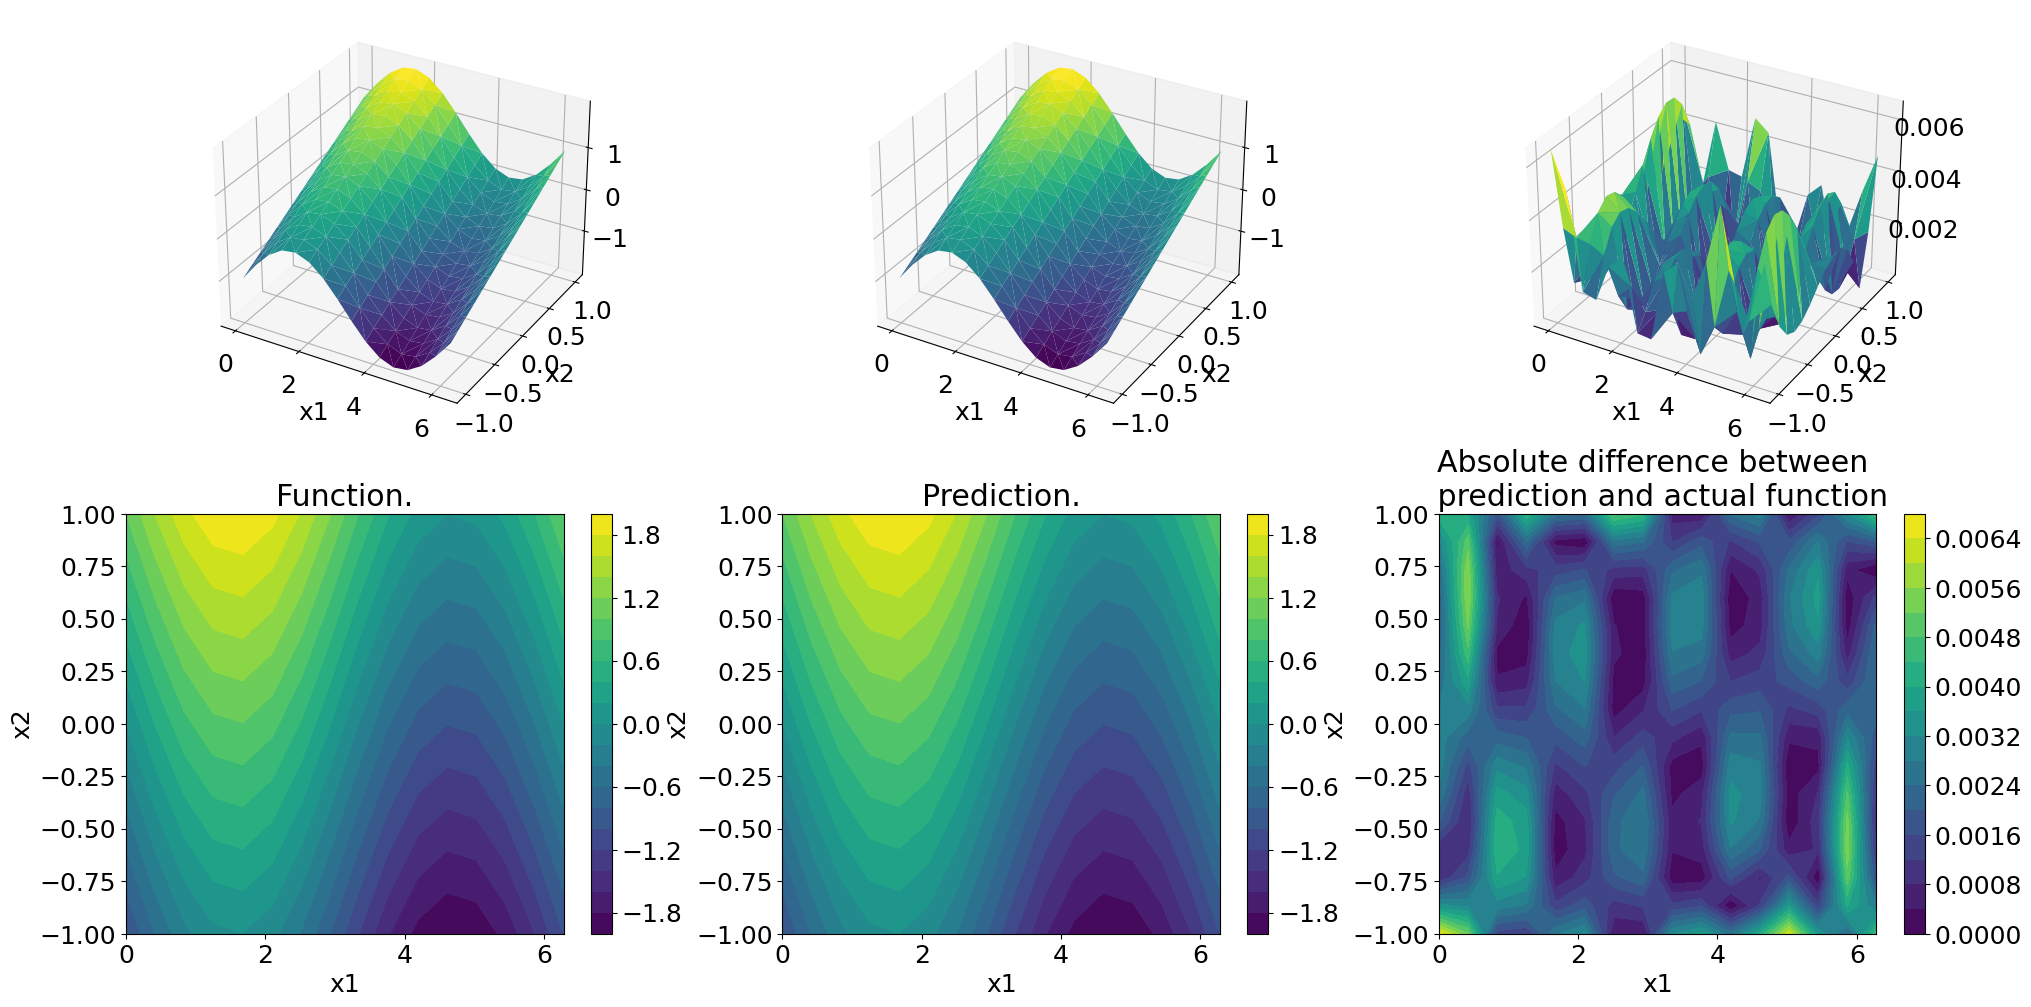

In [12]:
units = 10
epochs = 20000
res = approx_2d_function(x1, x2, units, epochs)
X1,X2 = np.meshgrid(x1,x2)
Y = my2dfun(X1,X2)
plot_2d_function(X1,X2,Y,res)